In [ ]:
!pip install --quiet opencv-python-headless matplotlib numpy scikit-image


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

os.makedirs("images", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

def show_pair(img1, img2, title1="Before", title2="After", cmap='gray', figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1); plt.imshow(img1, cmap=cmap); plt.title(title1); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img2, cmap=cmap); plt.title(title2); plt.axis('off')
    plt.show()

def overlay_contour_on_image(image, mask, color=(0,255,0), thickness=2):
    # find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    over = image.copy()
    cv2.drawContours(over, contours, -1, color, thickness)
    return over


In [ ]:
import requests
import cv2
import numpy as np
from skimage import io

# ✅ Step 1: Download 5 guaranteed images from Picsum
urls = [
    "https://picsum.photos/id/237/400/300",  # dog
    "https://picsum.photos/id/1025/400/300", # animal
    "https://picsum.photos/id/1003/400/300", # landscape
    "https://picsum.photos/id/1015/400/300", # mountain
    "https://picsum.photos/id/1024/400/300"  # bird
]

for i, url in enumerate(urls):
    fname = f"images/img_{i+1}.jpg"
    try:
        r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        if r.status_code == 200:
            with open(fname, "wb") as f:
                f.write(r.content)
            print(f"✅ Downloaded {fname}")
        else:
            print(f"❌ Failed ({r.status_code}) {url}")
    except Exception as e:
        print("Error:", url, e)


# ✅ Step 2: Create noisy masks (updated)
def create_predicted_mask(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def add_noise_to_mask(mask, noise_level=0.08):
    noisy = mask.copy()
    h, w = mask.shape
    n_pixels = int(h * w * noise_level)
    ys = np.random.randint(0, h, size=n_pixels)
    xs = np.random.randint(0, w, size=n_pixels)
    noisy[ys, xs] = 255 - noisy[ys, xs]
    return noisy

# ✅ Step 3: Generate masks successfully
for i in range(len(urls)):
    img = cv2.imread(f"images/img_{i+1}.jpg")
    if img is None:
        print(f"⚠️ Could not load image {i+1}. Skipping.")
        continue
    mask = create_predicted_mask(img)
    noisy = add_noise_to_mask(mask, noise_level=0.06)
    cv2.imwrite(f"images/mask_{i+1}_noisy.png", noisy)
    cv2.imwrite(f"images/mask_{i+1}_orig.png", mask)
    print(f"✅ Created noisy mask for image {i+1}")


✅ Downloaded images/img_1.jpg
✅ Downloaded images/img_2.jpg
✅ Downloaded images/img_3.jpg
✅ Downloaded images/img_4.jpg
✅ Downloaded images/img_5.jpg
✅ Created noisy mask for image 1
✅ Created noisy mask for image 2
✅ Created noisy mask for image 3
✅ Created noisy mask for image 4
✅ Created noisy mask for image 5


In [ ]:
def post_process_mask(noisy_mask,
                      thresh_method="binary",    # use simple binary thresholding after smoothing
                      morph_kernel_size=5,
                      opening_iter=1,
                      closing_iter=2,
                      smooth_kernel=5):
    # 1) Clean up types
    m = noisy_mask.copy()
    if m.max() > 1:
        m = (m > 127).astype(np.uint8) * 255

    # 2) Optional smoothing BEFORE threshold: median blur to remove salt-and-pepper
    m_blur = cv2.medianBlur(m, 3)

    # 3) Gaussian blur smoothing (helps shape) - used later as 'smoothing' too
    m_gauss = cv2.GaussianBlur(m_blur, (smooth_kernel|1, smooth_kernel|1), 0)

    # 4) Threshold again
    _, m_thresh = cv2.threshold(m_gauss, 127, 255, cv2.THRESH_BINARY)

    # 5) Morphological operations: opening then closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    m_open = cv2.morphologyEx(m_thresh, cv2.MORPH_OPEN, kernel, iterations=opening_iter)
    m_close = cv2.morphologyEx(m_open, cv2.MORPH_CLOSE, kernel, iterations=closing_iter)

    # 6) Optional contour smoothing: find largest contour and draw a smoothed approximation
    contours, _ = cv2.findContours(m_close.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    smoothed_mask = np.zeros_like(m_close)
    for cnt in contours:
        # approximate and draw
        epsilon = 0.005 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        cv2.drawContours(smoothed_mask, [approx], -1, 255, -1)

    # 7) Final small gaussian to remove stair artifacts, then threshold
    smoothed_mask = cv2.GaussianBlur(smoothed_mask, (5,5), 0)
    _, final_mask = cv2.threshold(smoothed_mask, 127, 255, cv2.THRESH_BINARY)
    return final_mask


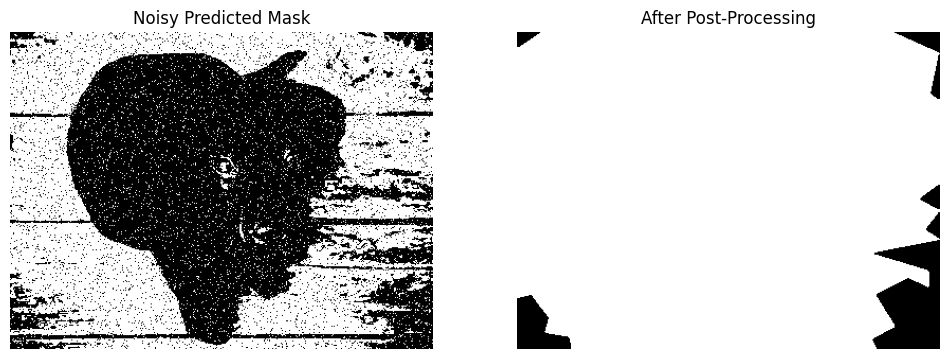

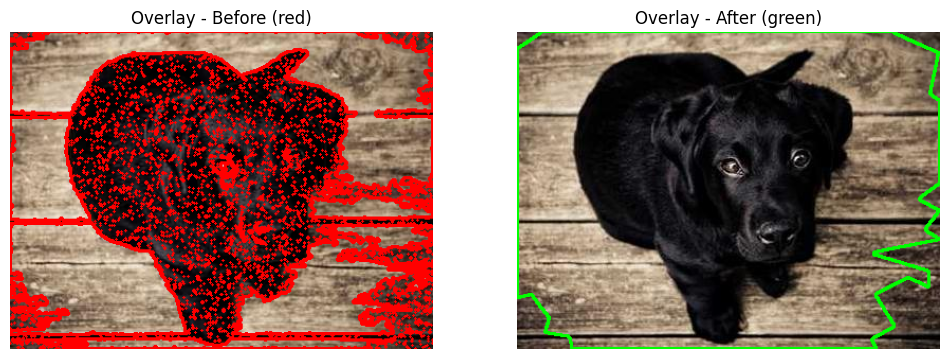

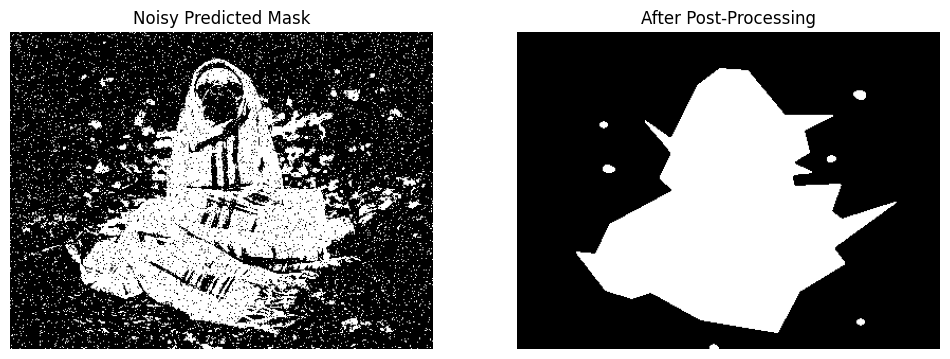

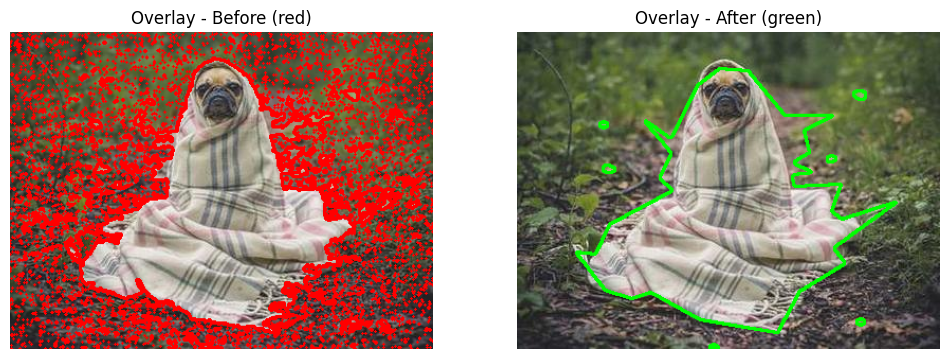

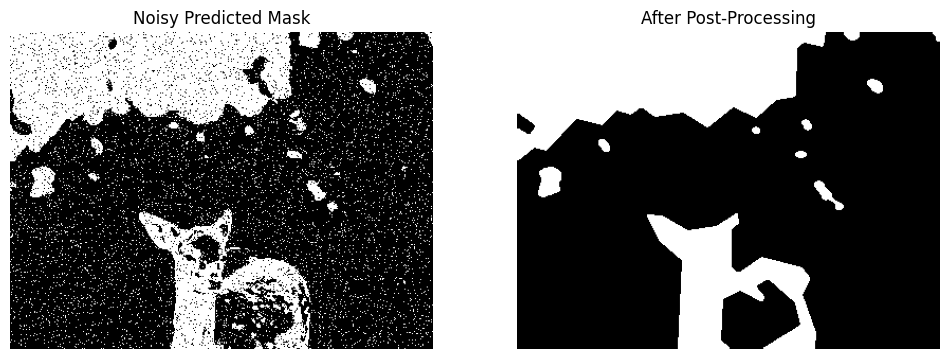

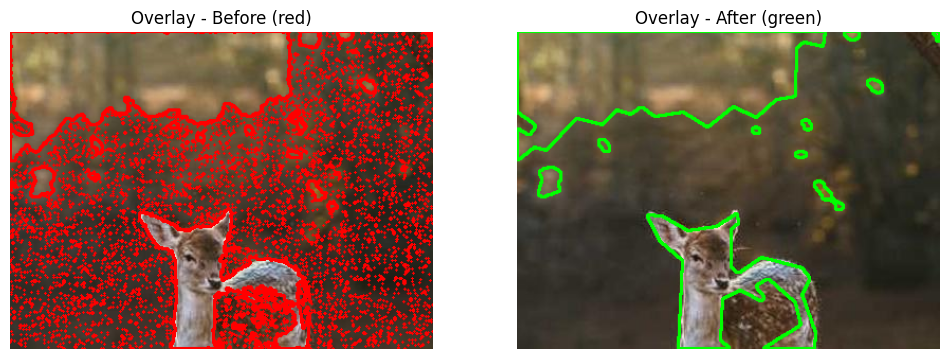

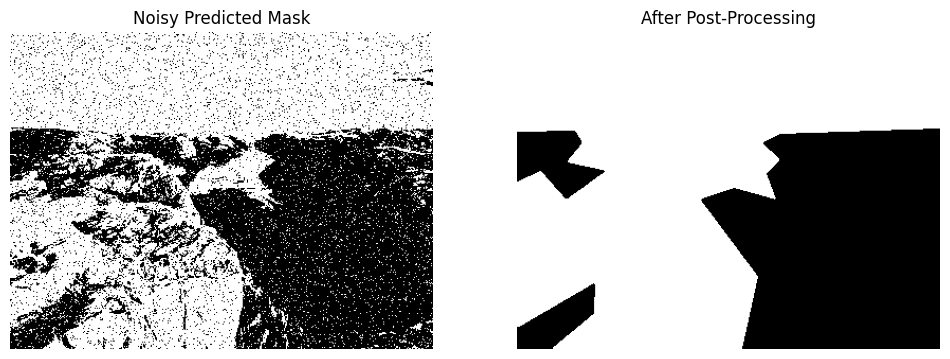

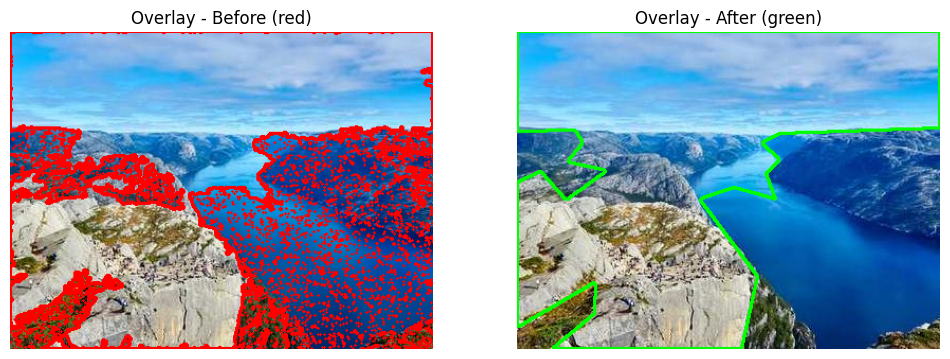

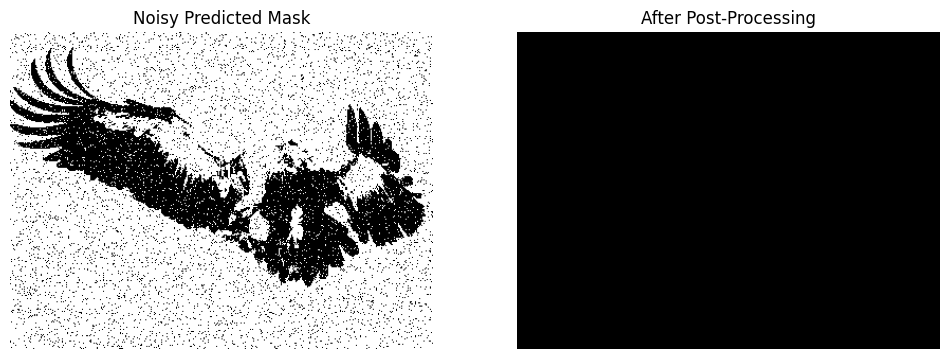

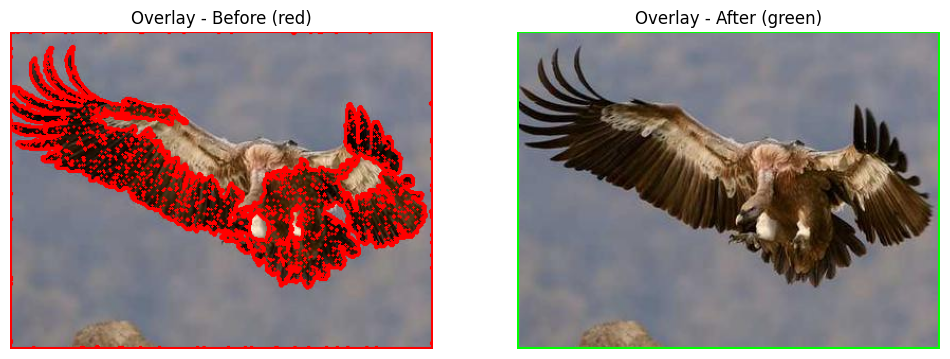

In [ ]:
for i in range(len(urls)):
    img_path = f"images/img_{i+1}.jpg"
    noisy_mask_path = f"images/mask_{i+1}_noisy.png"
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    noisy_mask = cv2.imread(noisy_mask_path, cv2.IMREAD_GRAYSCALE)

    processed = post_process_mask(noisy_mask,
                                  morph_kernel_size=7,
                                  opening_iter=1,
                                  closing_iter=2,
                                  smooth_kernel=7)

    # Save outputs
    cv2.imwrite(f"outputs/mask_{i+1}_processed.png", processed)

    # Visualize mask before vs after
    show_pair(noisy_mask, processed, title1="Noisy Predicted Mask", title2="After Post-Processing")

    # Overlay contours on original image
    overlay_before = overlay_contour_on_image(img_rgb, noisy_mask, color=(255,0,0), thickness=2)
    overlay_after = overlay_contour_on_image(img_rgb, processed, color=(0,255,0), thickness=2)
    show_pair(overlay_before, overlay_after, title1="Overlay - Before (red)", title2="Overlay - After (green)", cmap=None)


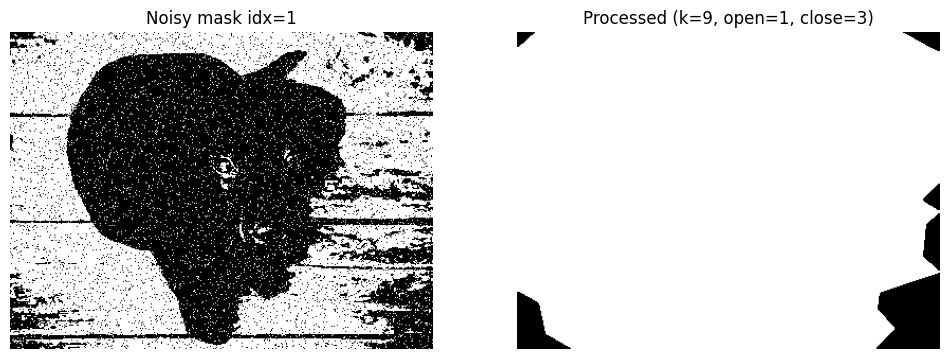

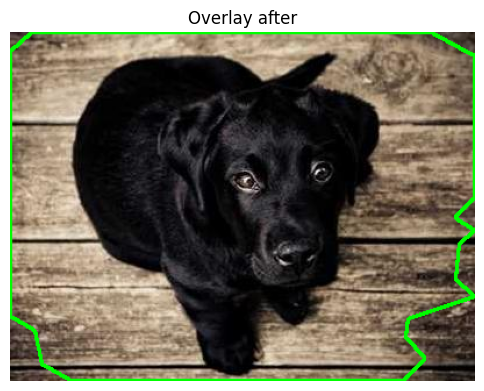

In [ ]:
# Quick function to run a single image with custom params
def run_and_display(idx, morph_kernel_size=5, opening_iter=1, closing_iter=2, smooth_kernel=5):
    img = cv2.imread(f"images/img_{idx}.jpg")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    noisy_mask = cv2.imread(f"images/mask_{idx}_noisy.png", cv2.IMREAD_GRAYSCALE)
    processed = post_process_mask(noisy_mask, morph_kernel_size=morph_kernel_size,
                                  opening_iter=opening_iter, closing_iter=closing_iter,
                                  smooth_kernel=smooth_kernel)
    show_pair(noisy_mask, processed, title1=f"Noisy mask idx={idx}", title2=f"Processed (k={morph_kernel_size}, open={opening_iter}, close={closing_iter})")
    ov = overlay_contour_on_image(img_rgb, processed)
    plt.figure(figsize=(6,6)); plt.imshow(ov); plt.axis('off'); plt.title('Overlay after'); plt.show()

# Example usage:
run_and_display(1, morph_kernel_size=9, opening_iter=1, closing_iter=3, smooth_kernel=9)


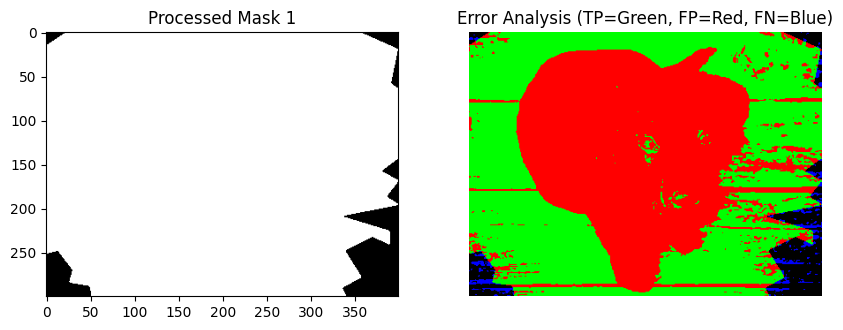

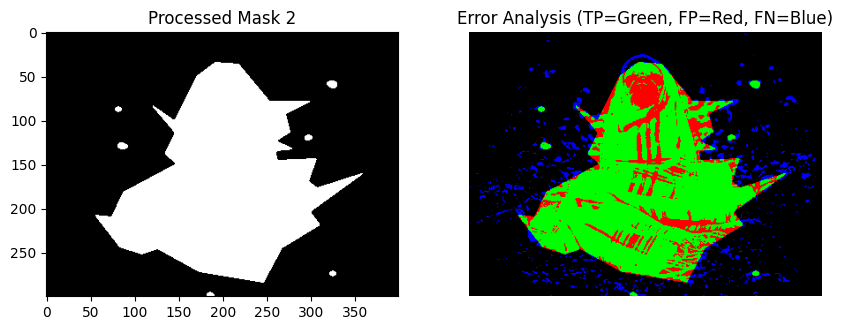

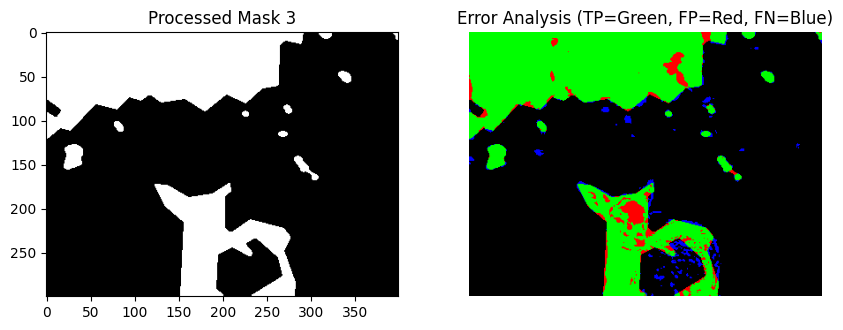

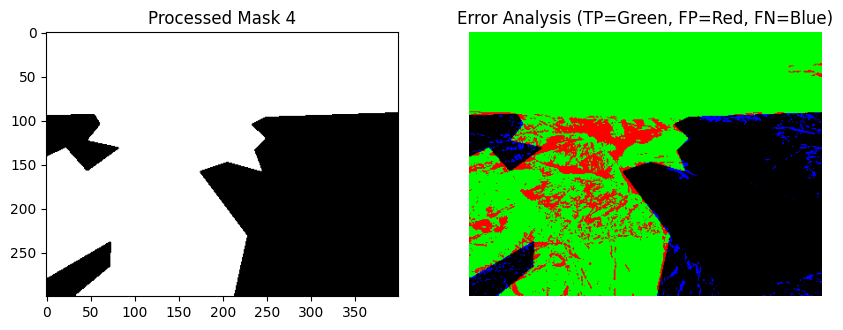

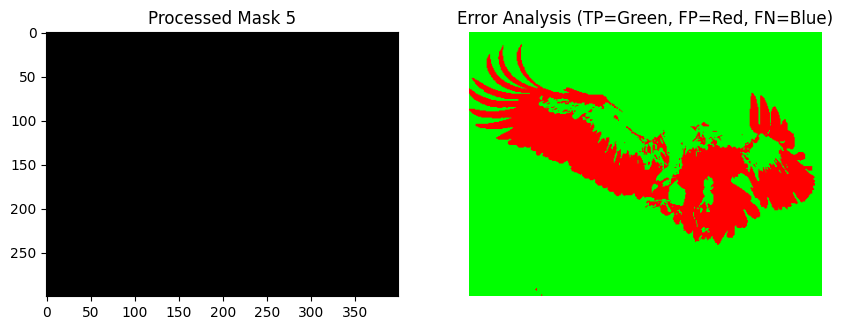

In [ ]:
def visualize_error_analysis(true_mask, pred_mask):
    # Resize to same shape
    true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]))
    true_mask_bin = (true_mask > 127).astype(np.uint8)
    pred_mask_bin = (pred_mask > 127).astype(np.uint8)

    # Create 3-channel visualization
    error_vis = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)

    # Assign colors
    fp = np.logical_and(pred_mask_bin == 1, true_mask_bin == 0)  # False Positive → RED
    fn = np.logical_and(pred_mask_bin == 0, true_mask_bin == 1)  # False Negative → BLUE
    tp = np.logical_and(pred_mask_bin == 1, true_mask_bin == 1)  # True Positive → GREEN

    error_vis[tp] = [0, 255, 0]      # Green
    error_vis[fp] = [255, 0, 0]      # Red
    error_vis[fn] = [0, 0, 255]      # Blue

    return error_vis

# Example usage (since we don’t have true ground truth, assume original "mask_orig" as ground truth)
for i in range(1, 6):
    true_mask = cv2.imread(f"images/mask_{i}_orig.png", cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(f"outputs/mask_{i}_processed.png", cv2.IMREAD_GRAYSCALE)
    if true_mask is None or pred_mask is None:
        continue
    error_img = visualize_error_analysis(true_mask, pred_mask)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(pred_mask, cmap='gray'); plt.title(f"Processed Mask {i}")
    plt.subplot(1,2,2); plt.imshow(error_img); plt.title(f"Error Analysis (TP=Green, FP=Red, FN=Blue)")
    plt.axis('off'); plt.show()
